In [2]:
from frf import FRF
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# Showcase of the package ``pyFRF``

Sep 2016, J. Slavič (janko.slavic@fs.uni-lj.si, [ladisk.si/~slavic](http://ladisk.si/~slavic))

pyFRF is part of the [www.openmodal.com](http://www.openmodal.com) project.

The inputs are time signals of excitation and response, the outputs are FRF estimators (H1, H2, Hv, Vector or ODS) and coherence.

## Create synthetic FRF

In [3]:
C = 0.5+0.1j # modal constant
eta = 5e-3   # damping loss factor
f0 = 320     # natural frequency
df = 1      # freq resolution
D = 1e-8*(1-.1j)    # residual

f = 1*np.arange(0, 1400, step=df) # / frequency range
    
w0 = f0 * 2 * np.pi #to rad/s
w = f * 2 * np.pi
H1_syn = C / (w0 ** 2 - w ** 2 + 1.j * eta * w0 ** 2) + \
        +0.5*np.conj(C) / ((w0*2)** 2 - w ** 2 + 1.j * eta * (w0*2)** 2)\
        +0.25*C / ((w0*3)** 2 - w ** 2 + 1.j * eta * (w0*3)** 2)\
        + D

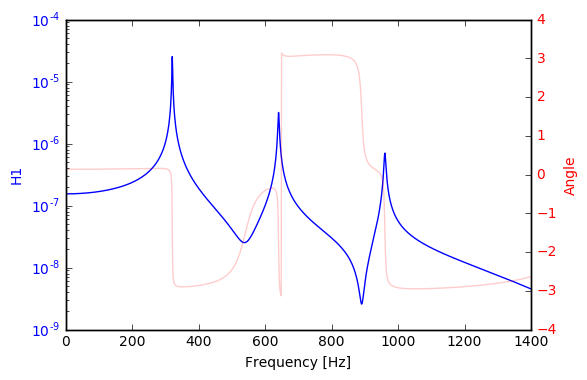

In [4]:
fig, ax1 = plt.subplots()
ax1.semilogy(f,np.abs(H1_syn), 'b')
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('H1', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
    
ax2 = ax1.twinx()
ax2.plot(f,np.angle(H1_syn), 'r', alpha=0.2)
ax2.set_ylabel('Angle', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

## Prepare synthetic impulse response

In [5]:
h = np.fft.irfft(H1_syn)
l = len(H1_syn)*2-2
t = np.arange(l)/(l-1)
exc = np.zeros_like(t)
exc[0] = 1

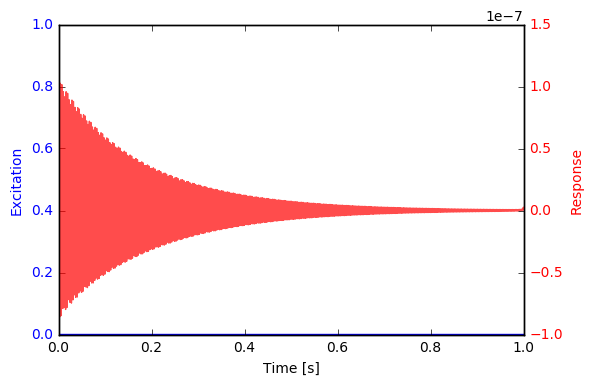

In [6]:
fig, ax1 = plt.subplots()
ax1.plot(t, exc, 'b');
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Excitation', color='b')
ax1.set_xlim(left=0, right=0.002)
for tl in ax1.get_yticklabels():
    tl.set_color('b')
    
ax2 = ax1.twinx()
ax2.plot(t, h, 'r', alpha=0.7)
ax2.set_ylabel('Response', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

## Go back to frequency domain via pyFRF

In [7]:
frf = FRF(sampling_freq=1/t[1], exc=exc, resp=h, exc_window='None', resp_window='None')

In [8]:
len(frf.get_f_axis())

1400

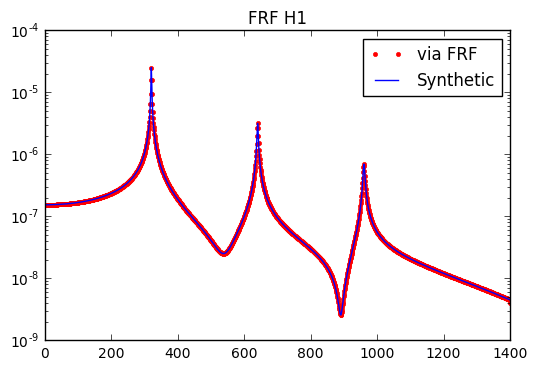

In [9]:
plt.semilogy(frf.get_f_axis(), np.abs(frf.get_H1()), 'r.', label='via FRF')
plt.semilogy(f, np.abs(H1_syn), label='Synthetic')
plt.title('FRF H1')
plt.legend();

## Go back to frequency domain via pyFRF - multiple measurements with noise

In [10]:
# prepare the instance of FRF 
averages = 10
frf = FRF(sampling_freq=1/t[1], fft_len=len(h), exc_window='None', resp_window='None', weighting='Linear', n_averages=averages)

In [11]:
k = 0.1 # rate of noise
for i in range(averages):
    noise = k * (np.random.rand(len(h))-0.5) * np.std(h)
    frf.add_data(exc, h + noise)

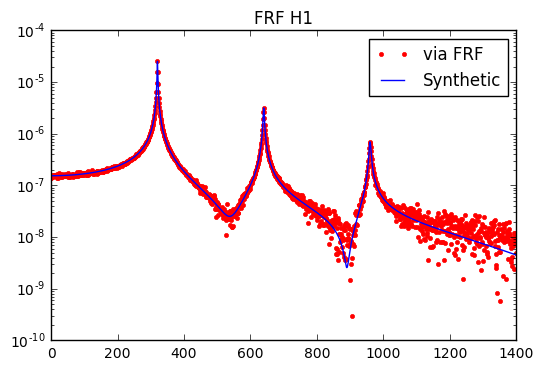

In [12]:
plt.semilogy(frf.get_f_axis(), np.abs(frf.get_H1()), 'r.', label='via FRF')
plt.semilogy(f, np.abs(H1_syn), label='Synthetic')
plt.title('FRF H1')
plt.legend();

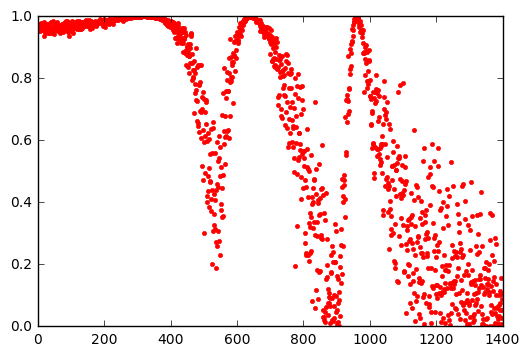

In [13]:
plt.plot(frf.get_f_axis(), frf.get_coherence(), 'r.');

## Measured data, from time domain to frequency domain - multiple measurements

Prepared by: Matej Razpotnik, matej.razpotnik@fs.uni-lj.si

In [16]:
import glob as glob

In [46]:
measurement_files = glob.glob('data/*')
first_meas = np.load(measurement_files[0])

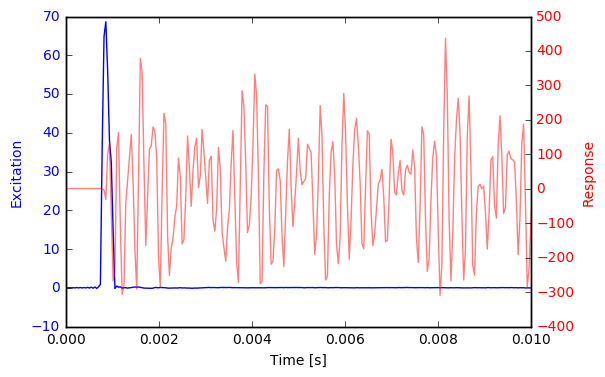

In [47]:
fig, ax1 = plt.subplots()
ax1.plot(first_meas[0], first_meas[1], 'b');
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Excitation', color='b')
ax1.set_xlim(left=0, right=0.002)
for tl in ax1.get_yticklabels():
    tl.set_color('b')
    
ax2 = ax1.twinx()
ax2.plot(first_meas[0], first_meas[2], 'r', alpha=0.5)
ax2.set_ylabel('Response', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
ax1.set_xlim(0, 0.01);

In [61]:
frf_meas = FRF(sampling_freq=1 / (first_meas[0][1] - first_meas[0][0]), 
               fft_len=len(first_meas[0]), 
               exc_window='Force:0.01', 
               resp_window='Exponential:0.01',
               weighting='Linear', 
               n_averages=len(measurement_files))

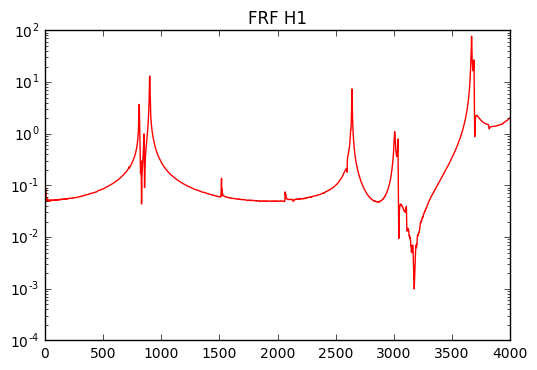

In [69]:
plot_up_to = 4000
for file_name in measurement_files:
    meas_i = np.load(file_name)
    frf_meas.add_data(meas_i[1], meas_i[2])
plt.semilogy(frf_meas.get_f_axis()[:plot_up_to], np.abs(frf_meas.get_H1())[:plot_up_to], 'r')
plt.title('FRF H1');

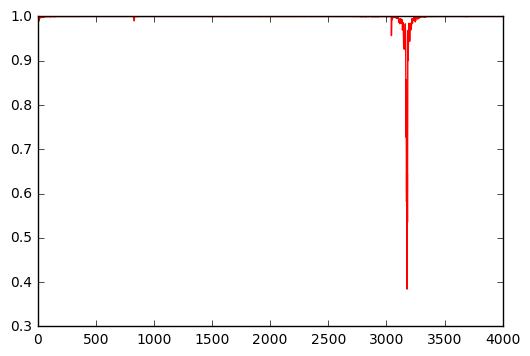

In [71]:
plt.plot(frf_meas.get_f_axis()[:plot_up_to], frf_meas.get_coherence()[:plot_up_to], 'r');